# Near2Far Optimization with Epigraph Formulation

The adjoint solver in meep now supports the adjoint simulation for near-to-far fields transformation. We present a simple optimization of metalens using the epigraph formulation.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal
mp.quiet(quietval=True)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

Basic setup

In [2]:
design_region_width = 32
design_region_height = 2

pml_size = 1.0

resolution = 30

Sx = design_region_width
Sy = 2*pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx,Sy)

nf = 2
frequencies = np.array([1/1.5, 1/1.6])

minimum_length = 0.09 # minimum length scale (microns)
eta_i = 0.5 # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55 # erosion design field thresholding point (between 0 and 1)
eta_d = 1-eta_e # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)
design_region_resolution = int(1*resolution)

pml_layers = [mp.PML(pml_size, direction=mp.Y)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [0,-(design_region_height/2 + 1.5),0]
source_size    = mp.Vector3(Sx,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    size = source_size,
                    center=source_center)]

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_SUM')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0)))

def mapping(x,eta,beta):
    # filter
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()

geometry = [
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables),
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables, e1=mp.Vector3(x=-1))] # design region
kpoint = mp.Vector3()
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=kpoint,
                    geometry=geometry,
                    sources=source,
                    default_material=SiO2,
                    symmetries=[mp.Mirror(direction=mp.X)],
                    resolution=resolution)

We will have two objective functions, one for each far point. However, we only need one `mpa.Near2FarFields` objective. We also need to provide a near-field monitor, from which the field at far point will be calculated. Only single monitor is supported right now, so the monitor needs to extend to the entire cell to capture all outgoing fields.

When evaluated, mpa.Near2FarFields will return a numpy array with shape npoints by nfreq by 6 numpy array, where the third axis corresponds to the field components $E_x, E_y, E_z, H_x, H_y, H_z$, in that order. We will specify a objective as a function of the field components at frequencies of interest at points of interest. In this case, we would like to optimize $|E_z|^2$, and focus the fields of different frequency at different points.

In [3]:
far_x = [mp.Vector3(0,35,0), mp.Vector3(0,40,0)]
NearRegions = [mp.Near2FarRegion(center=mp.Vector3(0,design_region_height/2+1.5), size=mp.Vector3(design_region_width+1.5,0), weight=+1)]
FarFields = mpa.Near2FarFields(sim, NearRegions ,far_x)
ob_list = [FarFields]
def J1(alpha):
    return -npa.abs(alpha[0,1,2])**2
def J2(alpha):
    return -npa.abs(alpha[1,0,2])**2

In [4]:
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = [J1,J2],
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies,
    decay_by = 1e-4,
    decay_fields=[mp.Ez],
    maximum_run_time = 1500
)

Our objective function that we pass to nlopt is rather simple. We'll introduce a dummy parameter `t`. The goal of the optimization problem will be to simply minimize the value of `t`. The gradient of this functional is rather straightforward.

In [5]:
evaluation_history = []
cur_iter = [0]
def f(x, grad):
    t = x[0] # "dummy" parameter
    v = x[1:] # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t

The key to the epigraph formulation (and most nonlinear optimization problems) lies in the constraints. We'll define one constraint for every frequency point of interest ($f_i$). We'll define our constraint as 

$$f_i < t$$

where $t$ is the previosuly defined dummy parameter. Each constraint function is then defined by

$$ c_i = f_i-t $$

within some tolerance.

More detail about this formulation can be found in the nlopt [documentation](https://nlopt.readthedocs.io/en/latest/NLopt_Introduction/#equivalent-formulations-of-optimization-problems).

In [6]:
def c(result,x,gradient,eta,beta):
    print("Current iteration: {}; current eta: {}, current beta: {}".format(cur_iter[0],eta,beta))
    
    t = x[0] # dummy parameter
    v = x[1:] # design parameters

    f0, dJ_du = opt([mapping(v,eta,beta)])

    # Backprop the gradients through our mapping function
    dJ_du = np.array(dJ_du)
    my_grad = np.zeros((len(dJ_du[0]),2))
    for k in range(2):
        my_grad[:,k] = tensor_jacobian_product(mapping,0)(v,eta,beta,np.sum(dJ_du[k,:,:],axis=1))

    # Assign gradients
    if gradient.size > 0:
        gradient[:,0] = -1 # gradient w.r.t. "t"
        gradient[:,1:] = my_grad.T # gradient w.r.t. each frequency objective
    
    result[:] = np.real(f0) - t
    
    # store results
    evaluation_history.append(np.real(f0))
    
    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    circ = Circle((2,2),minimum_length/2)
    ax.add_patch(circ)
    ax.axis('off')
    plt.show()
    
    cur_iter[0] = cur_iter[0] + 1


We'll now run our optimizer in loop. The loop will increase beta and reset the optimizer, which is important since the cost function changes.

Current iteration: 0; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.8/site-packages/meep/adjoint/filter_source.py:91: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat.T)**2/np.abs(H)**2)
/usr/local/lib/python3.8/site-packages/meep/adjoint/filter_source.py:91: RuntimeWarning: invalid value encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat.T)**2/np.abs(H)**2)


Calculating gradient...


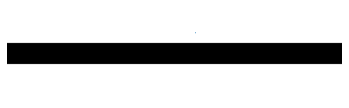

Current iteration: 1; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


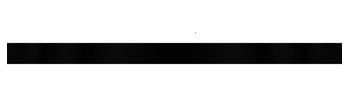

Current iteration: 2; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


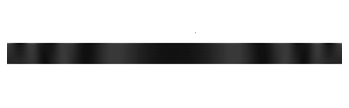

Current iteration: 3; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


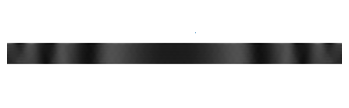

Current iteration: 4; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


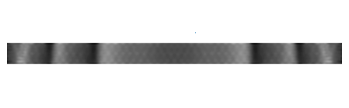

Current iteration: 5; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


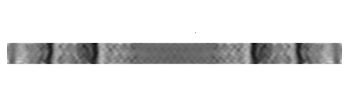

Current iteration: 6; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


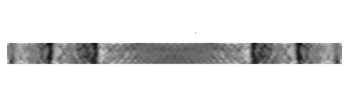

Current iteration: 7; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


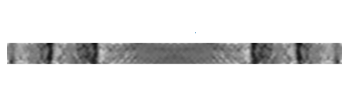

Current iteration: 8; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


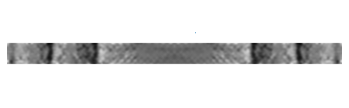

Current iteration: 9; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


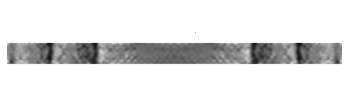

Current iteration: 10; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


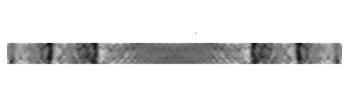

Current iteration: 11; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


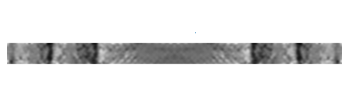

Current iteration: 12; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


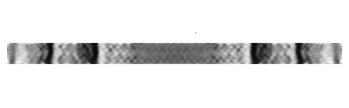

Current iteration: 13; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


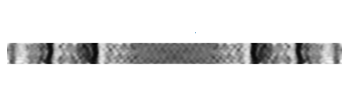

Current iteration: 14; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


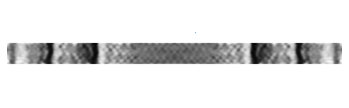

Current iteration: 15; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


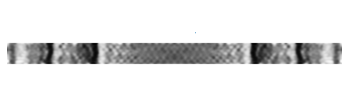

Current iteration: 16; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


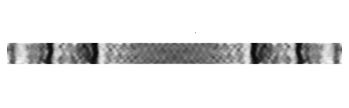

Current iteration: 17; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


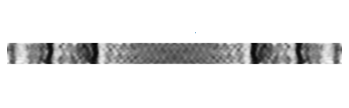

Current iteration: 18; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


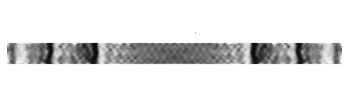

Current iteration: 19; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


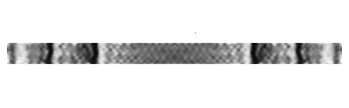

Current iteration: 20; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


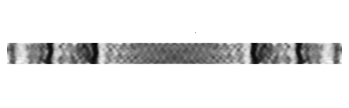

Current iteration: 21; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


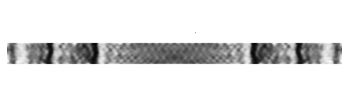

Current iteration: 22; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


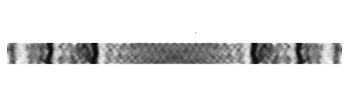

Current iteration: 23; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


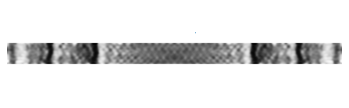

Current iteration: 24; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


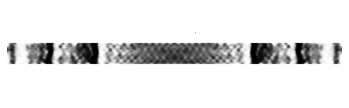

Current iteration: 25; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


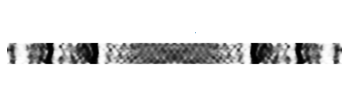

Current iteration: 26; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


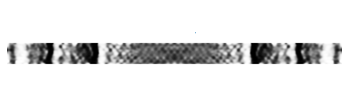

Current iteration: 27; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


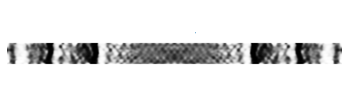

Current iteration: 28; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


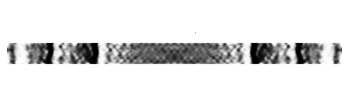

Current iteration: 29; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


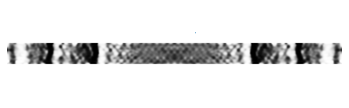

Current iteration: 30; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


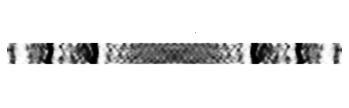

Current iteration: 31; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


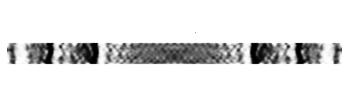

Current iteration: 32; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


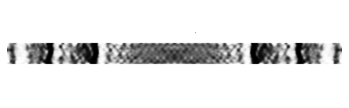

Current iteration: 33; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


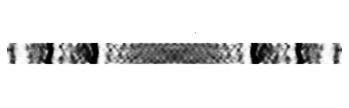

Current iteration: 34; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


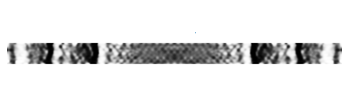

Current iteration: 35; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


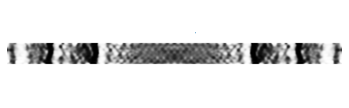

In [7]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx*Ny,))
ub = np.ones((Nx*Ny,))

# insert dummy parameter bounds and variable
x = np.insert(x,0,0) # our initial guess for the worst error
lb = np.insert(lb,0,-np.inf)
ub = np.insert(ub,0,0)

cur_beta = 32
beta_scale = 2
num_betas = 3
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n+1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(f)
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    solver.add_inequality_mconstraint(lambda r,x,g: c(r,x,g,eta_i,cur_beta), np.array([1e-3]*nf))
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale

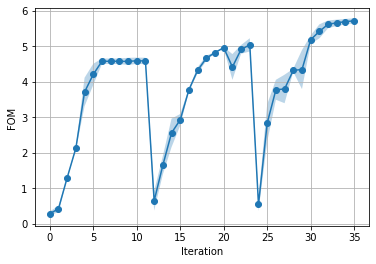

In [24]:
lb = -np.min(evaluation_history,axis=1)
ub = -np.max(evaluation_history,axis=1)
mean = -np.mean(evaluation_history,axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(np.arange(num_iters),ub,lb,alpha=0.3)
plt.plot(mean,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

We can plot our results and see the resulting geometry.

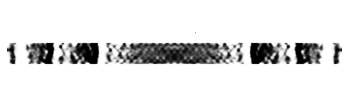

In [9]:
opt.update_design([mapping(x[1:],eta_i,cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
circ = Circle((2,2),minimum_length/2)
ax.add_patch(circ)
ax.axis('off')
plt.show()

To check the performance of our final structure, we use a CW source at the desired frequency and plot the fields after the struture.

<AxesSubplot:xlabel='X', ylabel='Y'>

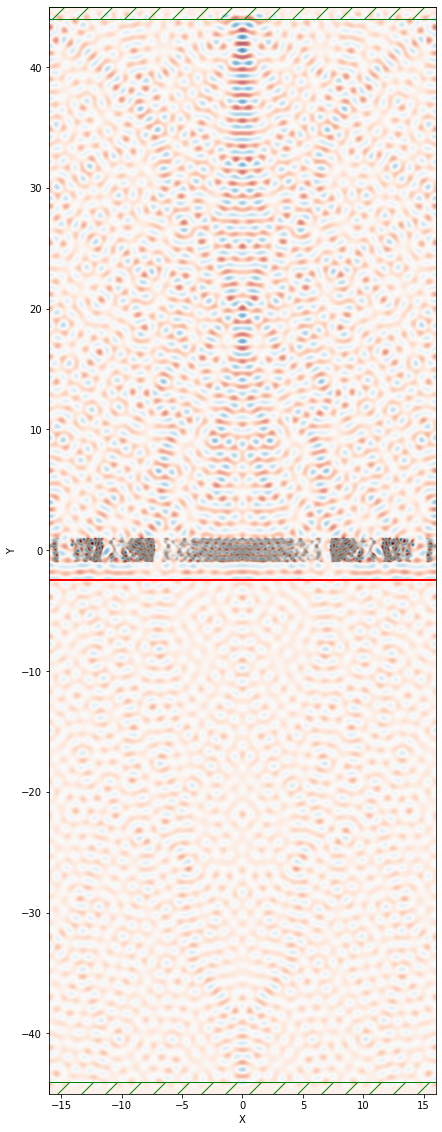

In [16]:
opt.sim = mp.Simulation(cell_size=mp.Vector3(Sx,90),
                    boundary_layers=pml_layers,
                    k_point=kpoint,
                    geometry=geometry,
                    sources=source,
                    default_material=SiO2,
                    resolution=resolution)
src = mp.ContinuousSource(frequency=1/1.5,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    size = source_size,
                    center=source_center)]
opt.sim.change_sources(source)

opt.sim.run(until=400)
plt.figure(figsize=(10,20))
opt.sim.plot2D(fields=mp.Ez)



<AxesSubplot:xlabel='X', ylabel='Y'>

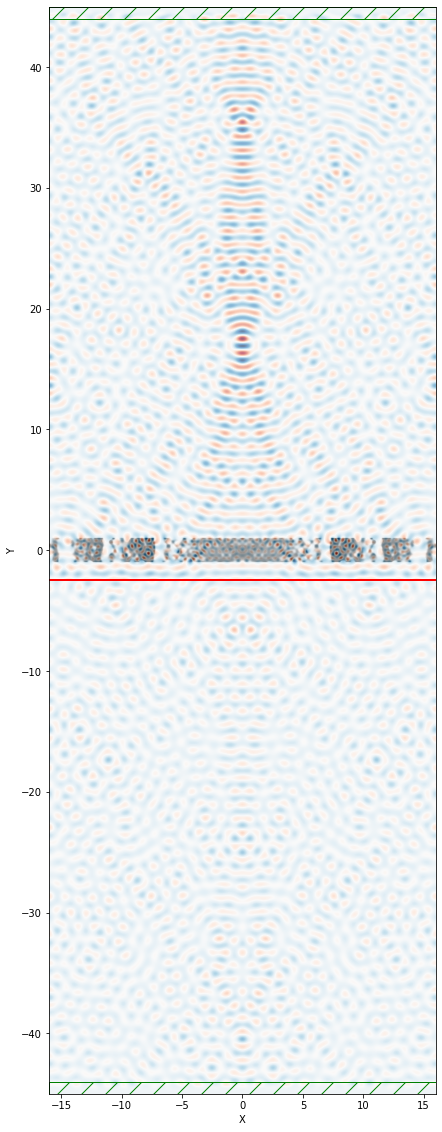

In [18]:
opt.sim = mp.Simulation(cell_size=mp.Vector3(Sx,90),
                    boundary_layers=pml_layers,
                    k_point=kpoint,
                    geometry=geometry,
                    sources=source,
                    default_material=SiO2,
                    resolution=resolution)
src = mp.ContinuousSource(frequency=1/1.6,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    size = source_size,
                    center=source_center)]
opt.sim.change_sources(source)

opt.sim.run(until=200)
plt.figure(figsize=(10,20))
opt.sim.plot2D(fields=mp.Ez)